<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/LogisticRegression_fwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the necessary packages**


In [1]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [2]:
%pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 6.1 MB/s eta 0:00:00


In [3]:
import torchmetrics
import torchvision

In [4]:
from torch import nn

In [5]:
from functorch import jvp
from functools import partial
import time 

In [6]:
import matplotlib.pyplot as plt

# **Loading and preprocessing the data**

In [7]:
#Load the dataset
penguins = tfds.load('penguins', as_supervised=True, split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/processed/1.0.0.incompleteGZ560O/penguins-train.tfrecord*...:   0…

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/processed/1.0.0. Subsequent calls will reuse this data.


In [8]:
X, y = penguins.batch(500).get_single_element()
X, y = X.numpy(), y.numpy()

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [10]:
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

In [11]:
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

# **Define Logistic Regression**

In [13]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self, input_size, w, b):
    super().__init__()
    self.weight = nn.Parameter(w)
    self.bias = nn.Parameter(b)

  def forward(self, x):
    x = x.reshape(1, -1)
    return torch.softmax(x@self.weight + self.bias, 1)

In [12]:
# We check if CUDA is available. 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# **Initialize the parameters**

In [14]:
# We initialize the parameters randomly and the model with an input size
w = torch.randn((4, 3), requires_grad=False)
b = torch.randn((3, ), requires_grad=False)
LG = SimpleLogisticRegression(4, w, b).to(device)

In [15]:
# We try our model with the first example
print(LG(Xtrain[0].to(device)))

tensor([[0.0387, 0.9158, 0.0455]], grad_fn=<SoftmaxBackward0>)


Calculate predictiones

In [16]:
def pred(x,w,b):
  ypred=torch.randn((x.shape[0],3))
  for j in range (x.shape[0]):
    xj = x[j].reshape(1, -1)
    ypred[j]=torch.softmax(xj@w+b,1)
  return ypred

In [17]:
ypred=pred(Xtrain,w,b)

# **Define accuarcy**

In [18]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [19]:
# Average accuracy at initialization is 33% (random guessing).
accuracy(ytrain.to(device), ypred.to(device))

tensor(0.2040)

# **Define Cross Entropy**

We have defined one cross entropy function for each parameter because we will define later partial functions and the parameters need to be in different order







In [22]:
def cross_entropyW(w, ytrue, x, b):
  ypred=torch.randn((ytrue.shape[0],3))
  for j in range (ytrue.shape[0]):
    xj = x[j].reshape(1, -1)
    ypred[j]=torch.softmax(xj@w+b,1)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [21]:
def cross_entropyB(b, ytrue, x, w):
  ypred=torch.randn((ytrue.shape[0],3))
  for j in range (ytrue.shape[0]):
    xj = x[j].reshape(1, -1)
    ypred[j]=torch.softmax(xj@w+b,1)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [27]:
# We check that the output of all the cross extropy functions is the same
print(cross_entropyB(b, ytrain.to(device),Xtrain.to(device), w))
print(cross_entropyW(w,ytrain.to(device),Xtrain.to(device),b))

tensor(1.8676)
tensor(1.8676)


## **Other optimization functions**

In [24]:
def beale_function(x):
  return (torch.pow(torch.tensor([1.5])-x[0]+x[0]*x[1],2) + torch.pow(torch.tensor([2.25])-x[0]+x[0]*torch.pow(x[1],2),2)+torch.pow(torch.tensor([2.625])-x[0]+x[0]*torch.pow(x[1],3),2))

In [25]:
def rosenbrock_function(x):
  sum=0
  for i in range (x.size(0) -1):
    sum += (100*torch.pow(x[i+1] - torch.pow(x[i], 2), 2) + torch.pow(1-x[i], 2))
  return sum

In [26]:
def sphere_function(x):
  sum=0
  for i in range(x.size(0)):
    sum += torch.pow(x[i], 2)
  return sum

# **Train and evaluate the network**


In [28]:
def train_fwd_gradient(x, y):

  x,y=x.to(device),y.to(device)

  losses = [] # Vector with the cross entropy values of test set
  accuracies = [] # Vector with the accuracy values of test set
  errors=[] # Vector with the number of misclassification of the test set

  l_rate0 = 0.2 # Learning rate used 

  # Initialize the parameters
  w = torch.randn((4, 3),requires_grad=False) 
  b = torch.randn((3, ),requires_grad=False)

  loss = cross_entropyW(w, y, x, b) # Loss function

  # Calculate the start time 
  t=0
  t0=time.time()
  print('Time', t, 'loss', loss)

  while (loss>0.3) :

    # vw and wb are defined as a perturbation vector taken as a multivariate random variable,such that their scalar components vi are independent for all i, and have zero mean and unit variance .

    vw=torch.randn(w.shape)
    vw = (vw - torch.mean(vw))/torch.std(vw)
    vb=torch.randn(b.shape)
    vb = (vb - torch.mean(vb))/torch.std(vb)

    # We define a partial function for each of the parameter
    fw = partial(cross_entropyW,ytrue=y, x=x, b=b)
    fb = partial(cross_entropyB,ytrue=y, x=x, w=w)

    # We compute the cross entropy and the directional derivative of cross entropy at each parameters in direction v, simultaneously and without having to compute ∇cross_entropy in the process
    # This is also know as formard-mode autodiff
    ftw, dtw = jvp(fw,(w, ), (vw, ))
    ftb, dtb = jvp(fb,(b, ), (vb, ))

    # We multiply the scalar directional derivative ∇cross_entropy(θ)·v with vector v and obtain g(θ), the forward gradient (where θ represents each one of out parameters)
    gtw = vw*dtw
    gtb = vb*dtb

    # Update the parameters
    w = w - l_rate0*gtw
    b = b - l_rate0*gtb

    # We calculate the number of misclassification of the test set with the updated model and we add to the errors vector
    LG = SimpleLogisticRegression(4, w, b)
    ypredT=torch.randn(Xtest.size(0),3)
    error=0
    for i in range (Xtest.size(0)):
      ypredT[i]=LG(Xtest[i])
      if (LG(Xtest[i]).argmax(1)- ytest[i])!=0:
        error = error+ 1

    
    errors.append(error)

    # We calculate the accuracy of the test set with the updated model and we add to the accuracy vector
    accuracies.append(accuracy(ytest,ypredT).item())

    # We calculate the cross_entropy of the test set with the updated model and we add to the accuracy vector
    loss=cross_entropyW(w, y, x, b)
    losses.append(loss)

    #We add the execution time of the iteration 
    t1=time.time()
    t+=t1-t0
    t0=t1

    print('Time', t, 'loss', loss)

  return w, b,errors,accuracies,losses

In [29]:
w, b,errors,accuracies,losses = train_fwd_gradient(Xtrain, ytrain)

Time 0 loss tensor(1.2306)
Time 0.40876293182373047 loss tensor(1.2296)
Time 0.6090469360351562 loss tensor(1.2055)
Time 0.7984132766723633 loss tensor(1.1318)
Time 1.0062692165374756 loss tensor(1.1292)
Time 1.2209925651550293 loss tensor(1.1037)
Time 1.4299402236938477 loss tensor(1.0554)
Time 1.5943713188171387 loss tensor(1.0477)
Time 1.731107234954834 loss tensor(1.0402)
Time 1.847700595855713 loss tensor(1.0279)
Time 1.9771628379821777 loss tensor(1.0187)
Time 2.1012659072875977 loss tensor(0.9977)
Time 2.226280450820923 loss tensor(0.9835)
Time 2.3488686084747314 loss tensor(0.9813)
Time 2.473414659500122 loss tensor(0.9741)
Time 2.5990407466888428 loss tensor(0.9383)
Time 2.7211225032806396 loss tensor(0.9282)
Time 2.8465449810028076 loss tensor(0.9088)
Time 2.9737110137939453 loss tensor(0.9056)
Time 3.0886425971984863 loss tensor(0.8961)
Time 3.2083799839019775 loss tensor(0.8892)
Time 3.324552297592163 loss tensor(0.8859)
Time 3.4456052780151367 loss tensor(0.8711)
Time 3.58

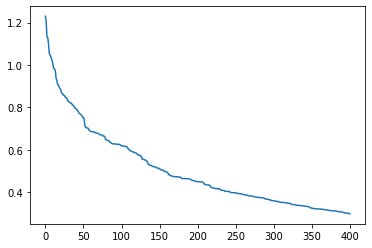

In [30]:
plt.plot(losses)

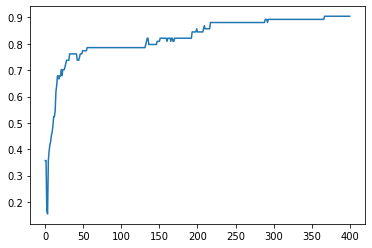

In [31]:
plt.plot(accuracies)

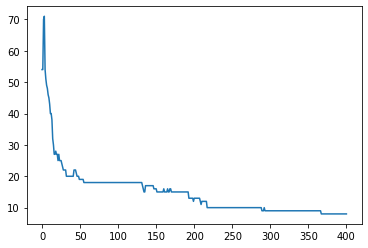

In [32]:
plt.plot(errors)